# Analysis of Strang-carryover with RK3 for AdImEx Advection
## Plan
- Discretise the advection equation in space using central differencing (CD) and upwind (UP), with CD as a correction on UP
- Represent the spatial discretisation with single Fourier modes
- Assume $k\Delta x=\pi/2$ to write the advection equation as an ODE
- Work out how to apply Strang-carryover adaptively implicitly (AdImEx) with high-order corrections treated explicitly.
- Analyse the stabiltiy of the Strang-carryover scheme

## Discretisation of the Advection Equation
\begin{eqnarray}
\frac{\partial \psi}{\partial t} &=& -u \frac{\partial \psi}{\partial x} \\
\frac{\partial \psi}{\partial x}_{jCD} = \frac{\psi_{j+1} - \psi_{j-1}}{2\Delta x}, &&
\frac{\partial \psi}{\partial x}_{jUP} = \frac{\psi_{j} - \psi_{j-1}}{\Delta x} \\
\text{Assume } \psi_j &=& e^{ikj\Delta x},\ c = u\Delta t/\Delta x,\ \lambda = u/\Delta x \\
\implies -u \frac{\partial \psi}{\partial x}_{jCD} &=& -\psi_j i \lambda \sin k\Delta x \\
\text{and } -u \frac{\partial \psi}{\partial x}_{jUP} &=& -\psi_j \lambda ( 1 - \cos k\Delta x + i\sin k\Delta x)\\
\text{Define } a=\sin k\Delta x , &&  d = 1 - \cos k\Delta x
\end{eqnarray}
The spatially discretised advection equation becomes
\begin{eqnarray}
\text{Upwind } \frac{dy}{dt} &=& -\lambda(d + ia)y \\
\text{CD } \frac{dy}{dt} &=& - i\lambda a y \\
\text{Analytic } \frac{dy}{dt} &=& - i\lambda k\Delta x y \\
\end{eqnarray}

We could consider a more general, higher-order discretisation of $\frac{\partial \psi}{\partial x}$:
\begin{eqnarray}
\frac{\partial \psi}{\partial x}_{HOj} &=& \frac{\psi_{j+1/2} - \psi_{j-1/2}}{\Delta x} \\
\text{where } \psi_{j+1/2} &=& \sum_{j+\ell} w_\ell\ \psi_{j+\ell}\\
\implies
\frac{\partial \psi}{\partial x}_{HOj} &=& \sum_{j+\ell} \frac{w_\ell\ \psi_{j+\ell}}{\Delta x}
                                    - \sum_{j+\ell-1} \frac{w_\ell\ \psi_{j+\ell}}{\Delta x}\\
\implies -u\frac{\partial \psi}{\partial x}_{HOj} &=& -\psi_j \lambda \left\{
\sum_\ell w_\ell\  e^{i\ell k\Delta x} - \sum_{\ell-1} w_\ell\  e^{i\ell k\Delta x}
\right\}
\end{eqnarray}


The spatially discretised advection equation can be written as a correction on upwind:
\begin{eqnarray}
\frac{dy}{dt} &=& -\lambda(\mu  + \eta) y\\
\text{where } \mu &=& 1-\cos k\Delta x + i\sin k\Delta x\\
\text{and }   \eta &=& -\mu + \left\{
\sum_\ell w_\ell\  e^{i\ell k\Delta x} - \sum_{\ell-1} w_\ell\  e^{i\ell k\Delta x}
\right\}
\end{eqnarray}

## Strang-carryover adaptively implicitly (AdImEx)
To solve
\begin{eqnarray}
\frac{dy}{dt} &=& -\lambda(\mu + \eta) y
\end{eqnarray}
with Strang-carryover with an arbitrary, explict, $s$-stage RK scheme in with Butcher-tableau coefficients $a_{ij}$:
\begin{eqnarray}
y^1 &=& y^{(n)} - c (1-\alpha)\beta \mu y^{(n)}\\
\text{for } i=1,...s,\ y^{i+1} &=& y^1 - c \sum_{j=1}^{i} a_{ij}\  y^j \left((1-\beta) \mu  + \gamma \eta \right) \\
y^{(n+1)} &=& y^{s+1} - c \alpha\beta \mu y^{(n+1)}
\end{eqnarray}
For RK3:
$$
(a_{ij}) = \left( \begin{array}{ccc}
1 & 0 & 0 \\
\frac{1}{4} & \frac{1}{4} & 0 \\
\frac{1}{6} & \frac{1}{6} & \frac{2}{3} 
\end{array}\right)
$$
Parameters $\alpha$, $\beta$ and $\gamma$ are set based on stability constraints and first guesses are:
\begin{eqnarray}
\text{off-centering, } && \alpha = \max(1/2,\ 1-1/c) \\
\text{implicit flag, } && \beta = \max(0,\ 1-1/c) \\
\text{high-order limiter, } && \gamma = \min(1, 6/(c+3.5)) \ ?
\end{eqnarray}

## Calculation of the Amplification factor

\begin{eqnarray}
A^1 &=& 1 - c(1-\alpha)\beta \mu \\
\text{for } i=1,...s,\ A^{i+1} &=& A^1 - c \left((1-\beta) \mu  + \gamma \eta \right) \sum_{j=1}^{i} a_{ij}\  A^j  \\
A &=& \frac{A^{s+1}}{1 + c \alpha\beta \mu}
\end{eqnarray}

## Weights for some spatial discretisations

Scheme | $w_{j-1}$ |  $w_j$  | $w_{j+1}$
------ |:---:|:---:|:---:
**Upwind** | | 1 |
**Linear** | | 1/2 | 1/2
**Linear Upwind** | -1/4 | 1 | 1/4
**Quasi-cubic**   | -1/6 | 5/6 | 1/3

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import matplotlib.pyplot as plt
#import fluidfoam as foam
from initialConditions import *
from advectionSchemeWeights import *

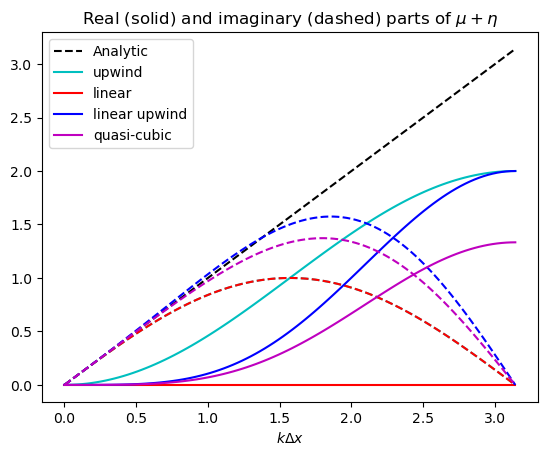

In [13]:
# mu and eta for some different spatial discretisations
def muEta(kdx, fluxWeights):
    mu = 1 - np.cos(kdx) + 1j*np.sin(kdx)
    eta = -mu
    indicies, weights = fluxWeights()
    for j,w in zip(indicies, weights):
        eta += w*(np.cos(j*kdx) + 1j*np.sin(j*kdx))
        eta -= w*(np.cos((j-1)*kdx) + 1j*np.sin((j-1)*kdx))
    return mu, eta

#print(muEta(np.pi/3, qCubic))

# Plot eta and mu
kdxs = np.linspace(0, np.pi, 100)
anal = 1j*kdxs
plt.plot(kdxs, anal.imag, 'k--', label='Analytic')
for scheme,label, col in zip([up, CD, linUp, qCubic], 
                        ['upwind','linear', 'linear upwind', 'quasi-cubic'],
                            ['c', 'r', 'b', 'm']):
    mu, eta = muEta(kdxs, scheme)
    plt.plot(kdxs, (mu+eta).real, col, label=label)
    plt.plot(kdxs, (mu+eta).imag, col+'--')
plt.legend()
plt.xlabel(r'$k\Delta x$')
plt.title(r'Real (solid) and imaginary (dashed) parts of $\mu+\eta$')
plt.show()

In [14]:
# Function to calculate the amplification factor for a scheme based on parameters
def Amp(a, alpha, beta, gamma, fluxWeights, c, kdx):
    if callable(beta):
        beta = beta(c)
    if callable(alpha):
        alpha = alpha(c)
    if callable(gamma):
        gamma = gamma(c)
    if callable(fluxWeights):
        mu, eta = muEta(kdx, fluxWeights)
    else:
        [mu, eta] = fluxWeights
    s = len(a)
    A = np.empty([s+2], dtype=np.complex128)
    A[0] = 1 + 0*1j - c*(1 - alpha)*beta*mu
    for i in range(len(a)):
        A[i+1] = A[0]
        for j in range(i+1):
            A[i+1] -= c*a[i][j]*A[j]*((1-beta)*mu + gamma*eta)
    A[-1] = A[-2]/(1 + c*alpha*beta*mu)
    return A[-1]

def Amps(a, alpha, beta, gamma, fluxWeights, cs, kdxs):
    """The amplification factor for a range of cs and kdxs"""
    A = np.empty([len(cs), len(kdxs)], np.complex128)
    for ic in range(len(cs)):
        for ik in range(len(kdxs)):
            c = cs[ic]
            kdx = kdxs[ik]
            A[ic,ik] = Amp(a, alpha, beta, gamma, fluxWeights, c, kdx)
    return A

def maxAmps(a, alpha, beta, gamma, fluxWeights, cs, nkdx = 40):
    """Maximum amplitude of the amplification factor for a range of Courant numbers, cs, over nkdx 
    values of kdx between zero and pi"""
    A = np.zeros(len(cs))
    kdxs = np.linspace(0, np.pi, nkdx)
    for ic in range(len(cs)):
        A[ic] = 0
        c = cs[ic]
        for ik in range(nkdx):
            kdx = kdxs[ik]
            magA = abs(Amp(a, alpha, beta, gamma, fluxWeights, c, kdx))
            A[ic] = max(A[ic], magA)
    return A

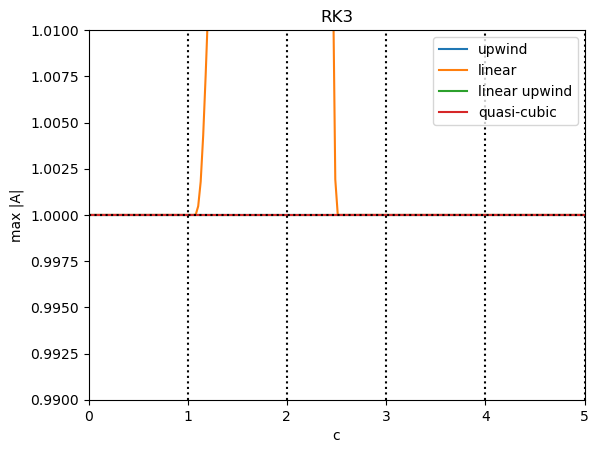

In [15]:
# Maximum Amplification factor magnitudes for some schemes
RK3 = [[1,0,0],[0.25,0.25,0], [1/6,1/6,2/3]]
RK2 = [[1,0],[0.5,0.5]]
RK1 = [[1]]
alpha = lambda c : 1-1/max(2,c)
beta = lambda c : 1-1/max(1,c)
gamma = lambda c: 1/max(1,c/2)
cs = np.linspace(0, 5, 200)
for RK, title in zip([RK3], ['RK3']):
    for space,label in zip([up, CD, linUp, qCubic], ['upwind', 'linear', 'linear upwind', 'quasi-cubic']):
        A = maxAmps(RK, alpha, beta, gamma, space, cs)
        plt.plot(cs, A, label = label)
    plt.title(title)
    plt.xlabel('c')
    plt.ylabel('max |A|')
    plt.xlim([0,5])
    plt.ylim([0.99,1.01])
    plt.axhline(y=1, ls=':', color='k')
    plt.axvline(x=1, ls=':', color='k')
    plt.axvline(x=2, ls=':', color='k')
    plt.axvline(x=3, ls=':', color='k')
    plt.axvline(x=4, ls=':', color='k')
    plt.axvline(x=5, ls=':', color='k')
    plt.legend()
    plt.show()

In [18]:
# Maximum Amplification factor magnitudes for some qCubic for various alpha, beta, gamma
cs = np.linspace(0, 40, 80)
gs = np.linspace(0, 1, 41)
als = np.linspace(0.5, 1, 11)
bs = np.linspace(0,1,21)

Aa = np.zeros([len(als),len(cs)])
Ab = np.zeros([len(bs),len(cs)])
Ag = np.zeros([len(gs),len(cs)])
Ai = np.zeros([len(gs),len(cs)])

for ia in range(len(als)):
    a = als[ia]
    Aa[ia,:] = maxAmps(RK3, a, beta, 0, qCubic, cs)

for ib in range(len(bs)):
    b = bs[ib]
    Ab[ib,:] = maxAmps(RK3, 0.5, b, 0, qCubic, cs)

for ig in range(len(gs)):
    g = gs[ig]
    Ag[ig,:] = maxAmps(RK3, alpha, beta, g, qCubic, cs)

for ig in range(len(gs)):
    g = gs[ig]
    Ai[ig,:] = maxAmps(RK3, 0.5, 1, g, qCubic, cs)

/tmp/ipykernel_135240/2193059242.py:3: UserWarning: No contour levels were found within the data range.
  plt.contour(cs, als, Aa, [1,100], colors='w')


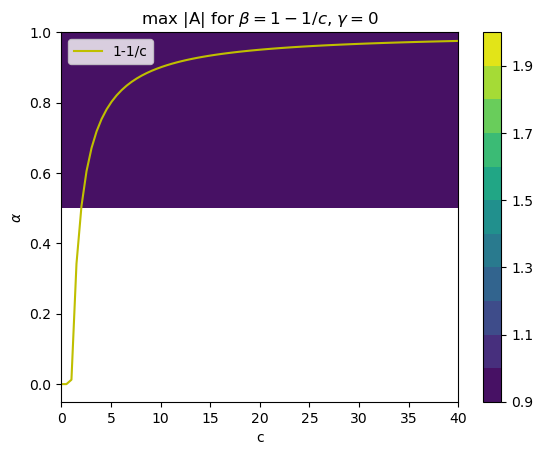

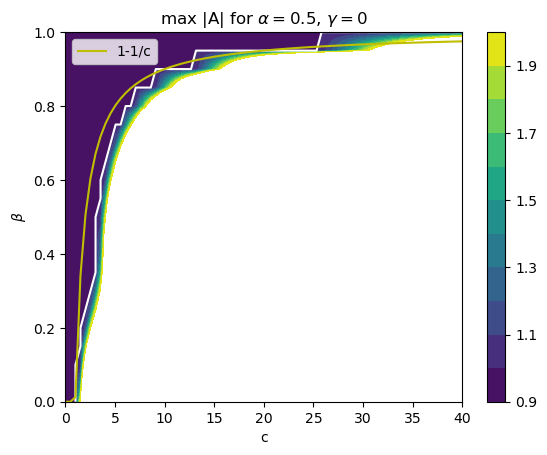

In [7]:
plt.contourf(cs, als, Aa, np.linspace(0.9, 2, 12))
plt.colorbar()
plt.contour(cs, als, Aa, [1,100], colors='w')
plt.plot(cs, 1-1/np.maximum(1,cs), 'y', label='1-1/c')
plt.legend()
plt.xlabel('c')
plt.ylabel(r'$\alpha$')
plt.title(r'max |A| for $\beta=1-1/c$, $\gamma=0$')
plt.show()

plt.contourf(cs, bs, Ab, np.linspace(0.9, 2, 12))
plt.colorbar()
plt.contour(cs, bs, Ab, [1,100], colors='w')
plt.plot(cs, 1-1/np.maximum(1,cs), 'y', label='1-1/c')
plt.legend()
plt.xlabel('c')
plt.ylabel(r'$\beta$')
plt.title(r'max |A| for $\alpha=0.5$, $\gamma=0$')
plt.show()

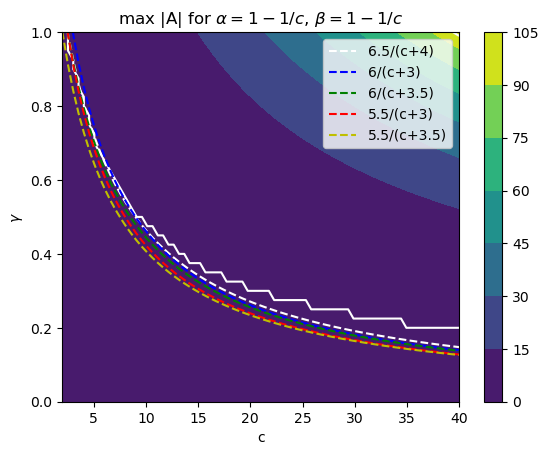

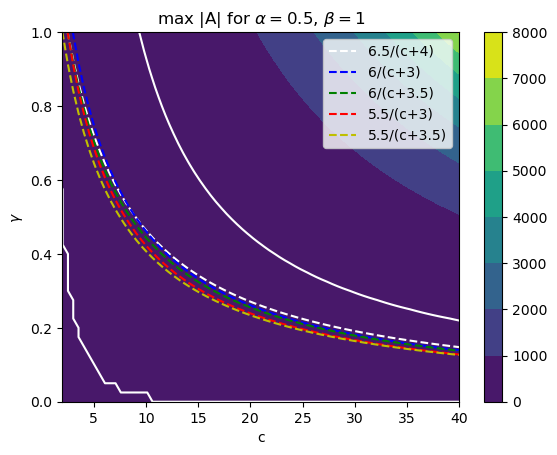

In [20]:
plt.contourf(cs, gs, Ag)
plt.colorbar()
plt.contour(cs, gs, Ag, [1,100], colors='w')
plt.plot(cs, 6.5/np.maximum(1, cs+4), 'w--', label='6.5/(c+4)')
plt.plot(cs, 6/np.maximum(1, cs+3), 'b--', label='6/(c+3)')
plt.plot(cs, 6/np.maximum(1, cs+3.5), 'g--', label='6/(c+3.5)')
plt.plot(cs, 5.5/np.maximum(1, cs+3), 'r--', label='5.5/(c+3)')
plt.plot(cs, 5.5/np.maximum(1, cs+3.5), 'y--', label='5.5/(c+3.5)')
plt.xlim([2,40])
plt.ylim([0,1])
plt.legend()
plt.xlabel('c')
plt.ylabel(r'$\gamma$')
plt.title(r'max |A| for $\alpha=1-1/c$, $\beta=1-1/c$')
plt.savefig('plots/AadImExgamma.pdf')
plt.show()

plt.contourf(cs, gs, Ai)
plt.colorbar()
plt.contour(cs, gs, Ai, [1,100], colors='w')
plt.plot(cs, 6.5/np.maximum(1, cs+4), 'w--', label='6.5/(c+4)')
plt.plot(cs, 6/np.maximum(1, cs+3), 'b--', label='6/(c+3)')
plt.plot(cs, 6/np.maximum(1, cs+3.5), 'g--', label='6/(c+3.5)')
plt.plot(cs, 5.5/np.maximum(1, cs+3), 'r--', label='5.5/(c+3)')
plt.plot(cs, 5.5/np.maximum(1, cs+3.5), 'y--', label='5.5/(c+3.5)')
plt.xlim([2,40])
plt.ylim([0,1])
plt.legend()
plt.xlabel('c')
plt.ylabel(r'$\gamma$')
plt.title(r'max |A| for $\alpha=0.5$, $\beta=1$')
plt.savefig('plots/AadImgamma.pdf')
plt.show()

/tmp/ipykernel_135240/2742694590.py:8: UserWarning: No contour levels were found within the data range.
  plt.contour(cs, kdxs, abs(A), [1,100])


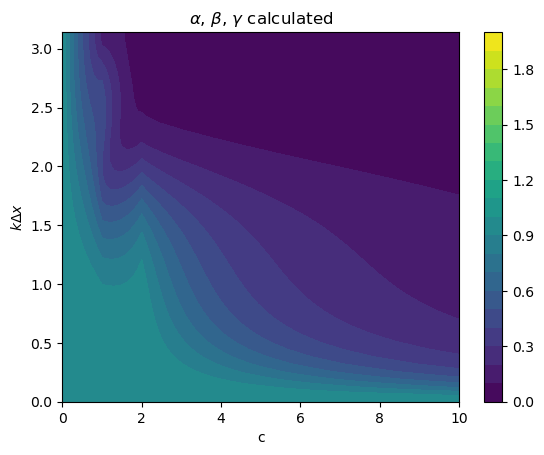

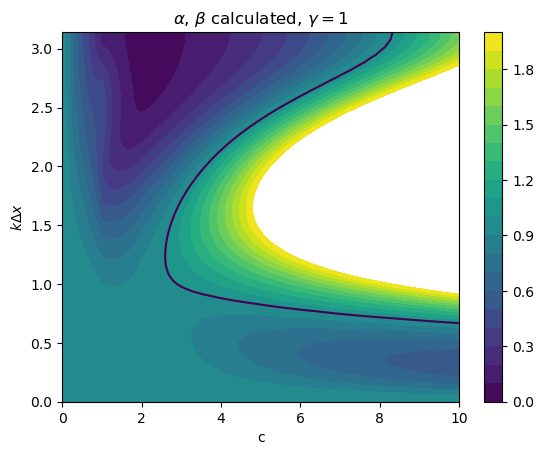

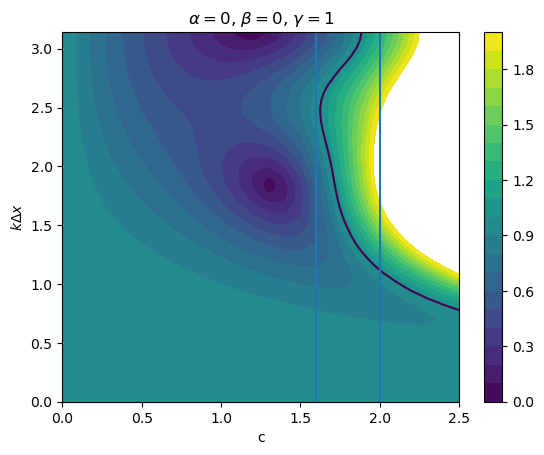

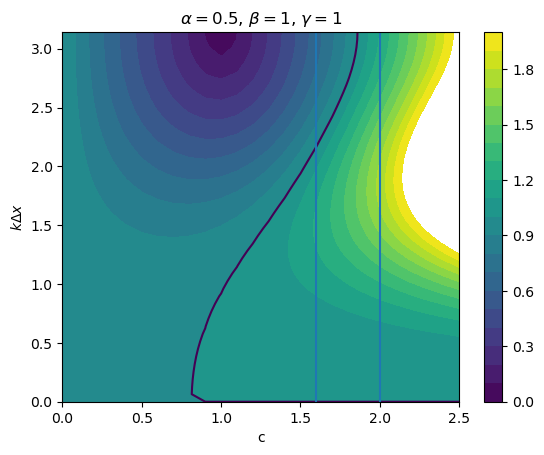

In [9]:
# Amplification factors for some schemes for all kdx
kdxs = np.linspace(0, np.pi, 50)
cs = np.linspace(0, 10, 101)
gammaqC = lambda c: 1/max(1, c/2)
A = (Amps(RK3, alpha, beta, gammaqC, qCubic, cs, kdxs)).transpose()
plt.contourf(cs, kdxs, abs(A), np.linspace(0, 2,21))
plt.colorbar()
plt.contour(cs, kdxs, abs(A), [1,100])
plt.xlabel('c')
plt.ylabel(r'$k\Delta x$')
plt.title(r'$\alpha$, $\beta$, $\gamma$ calculated')
plt.show()

A = (Amps(RK3, alpha, beta, 1, qCubic, cs, kdxs)).transpose()
plt.contourf(cs, kdxs, abs(A), np.linspace(0, 2,21))
plt.colorbar()
plt.contour(cs, kdxs, abs(A), [1,100])
plt.xlabel('c')
plt.ylabel(r'$k\Delta x$')
plt.title(r'$\alpha$, $\beta$ calculated, $\gamma=1$')
plt.show()

A = (Amps(RK3, 0, 0, 1, qCubic, cs, kdxs)).transpose()
plt.contourf(cs, kdxs, abs(A), np.linspace(0, 2,21))
plt.colorbar()
plt.contour(cs, kdxs, abs(A), [1,100])
plt.xlabel('c')
plt.ylabel(r'$k\Delta x$')
plt.axvline(x=1.6)
plt.axvline(x=2)
plt.xlim([0,2.5])
plt.title(r'$\alpha=0$, $\beta=0$, $\gamma=1$')
plt.show()

A = (Amps(RK3, 0.5, 1, 1, qCubic, cs, kdxs)).transpose()
plt.contourf(cs, kdxs, abs(A), np.linspace(0, 2,21))
plt.colorbar()
plt.contour(cs, kdxs, abs(A), [1,100])
plt.xlabel('c')
plt.ylabel(r'$k\Delta x$')
plt.axvline(x=1.6)
plt.axvline(x=2)
plt.xlim([0,2.5])
plt.title(r'$\alpha=0.5$, $\beta=1$, $\gamma=1$')
plt.show()

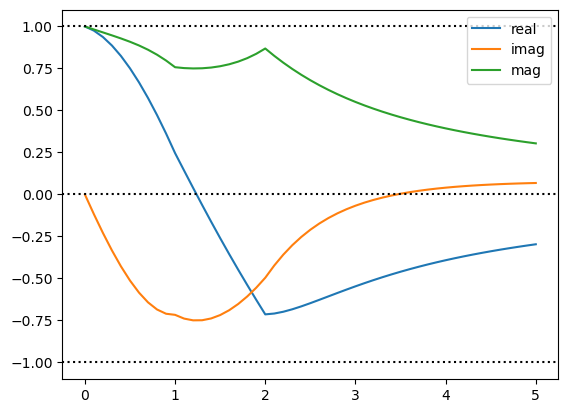

In [14]:
# Analyse qC with RK3 for kdx = pi/2
kdx = 1.3 #np.pi/2
mu, eta = muEta(kdx, qCubic)
cs = np.linspace(0, 5, 51)
A = Amps(RK3, alpha, beta, gammaqC, [mu, eta], cs, [kdx])
plt.plot(cs, A.real, label='real')
plt.plot(cs, A.imag, label='imag')
plt.plot(cs, abs(A), label='mag')
plt.axhline(y=1, color='k', ls=':')
plt.axhline(y=0, color='k', ls=':')
plt.axhline(y=-1, color='k', ls=':')
plt.legend()
plt.show()